In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(SeuratObject)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(reticulate)
    library(gridExtra)
    library(grid)
    library(ggpubr)
    library(scales)
    library(patchwork)
    library(stringr)
    library(future)
    library(data.table)
    library(Matrix)
    library(iSEE)
}))
use_condaenv("R42")
source_python("/home/vsevim/prj/workflows/ckd/secondary/mixture.py")

In [2]:
# Definitions etc
set.seed(1234)
options(digits=2)
stats <- c()

options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

custom_theme <- theme(
plot.title = element_text(size=16, hjust = 0.5), 
legend.key.size = unit(0.7, "cm"), 
legend.text = element_text(size = 14))

In [4]:
options(digits=2)

# Load guide-capture data

Define paths etc

In [3]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "NO"

    h5_name = "/home/jupyter-ayang/notebooks/cat-atac_pipeline/K562/secondary/output/seurat/CATATAC_K562_CRISPR_ONLY_SINGLETS.h5seurat"
    protosp_path = "/home/jupyter-ayang/notebooks/cat-atac_pipeline/K562/primary/output/resources/ps_long_sep.tsv"
    library = "K562_CRISPR"
    tsv_path = "/home/jupyter-ayang/notebooks/cat-atac_pipeline/K562/primary/output/tsv"
}

In [5]:
h5_w_gcap_name <- sub(".h5seurat", "_w_GUIDE_CAP.h5seurat", h5_name)
barcode2guide_tsv_path <- paste0(tsv_path, "/", library, "_ALL_STRUCTURED.TSV")
tsv_name <- paste0(tsv_path, "/", library, "_guide_PIVOT.TSV")
min_guide_count = 10

In [6]:
tsv_name

[1] "/home/jupyter-ayang/notebooks/cat-atac_pipeline/K562/primary/output/tsv/K562_CRISPR_guide_PIVOT.TSV"

### Load protospacer file

In [7]:
df_protosp = read.table(protosp_path, header=TRUE, comment.char="")

In [8]:
tfs_w_ntctl    = unique(df_protosp$X.TargetGene)
unselect_ntctl = (tfs_w_ntctl != "NTCTL") & (tfs_w_ntctl != "NTCTRL")
tfs_to_plot    = tfs_w_ntctl[unselect_ntctl]

guides_to_plot  = df_protosp$GuideName
tfs_to_plot
guides_to_plot

NULL

[1] "ARID1A_1" "ARID1A_2" "ARID1A_3" "ARID1A_4" "ATRX_1"   "ATRX_2"  
 [7] "ATRX_3"   "ATRX_4"   "CHD8_1"   "CHD8_2"   "CHD8_3"   "CHD8_4"  
[13] "DNMT3A_1" "DNMT3A_2" "DNMT3A_3" "DNMT3A_4" "EZH2_1"   "EZH2_2"  
[19] "EZH2_3"   "EZH2_4"   "HDAC9_1"  "HDAC9_2"  "HDAC9_3"  "HDAC9_4" 
[25] "KDM6A_1"  "KDM6A_2"  "KDM6A_3"  "KDM6A_4"  "MBD1_1"   "MBD1_2"  
[31] "MBD1_3"   "MBD1_4"   "NTCTL_1"  "NTCTL_2"  "NTCTL_3"  "NTCTL_4" 
[37] "PBRM1_1"  "PBRM1_2"  "PBRM1_3"  "PBRM1_4"  "PRDM9_1"  "PRDM9_2" 
[43] "PRDM9_3"  "PRDM9_4"  "SETD2_1"  "SETD2_2"  "SETD2_3"  "SETD2_4" 
[49] "TET2_1"   "TET2_2"   "TET2_3"   "TET2_4"

In [9]:
#c("OTP", "MYF6", "MEIS1", "FLI1", "HHEX", "HOXA6", "ELF5", "GBX1", "DPRX", "NTCTL")
##!! tf_list   <- tfs_w_ntctl 

df_guide <- read.table(tsv_name, header = TRUE, sep = "\t", quote = "")
tf_list  <- intersect(guides_to_plot, colnames(df_guide))

guide_counts  <- t(data.matrix(df_guide[,tf_list]))
colnames(guide_counts) <- df_guide$barcode_dash

In [10]:
colnames(df_guide)
guides_to_plot

[1] "barcode"      "n_guides"     "na"           "ARID1A_1"     "ARID1A_2"    
 [6] "ARID1A_3"     "ARID1A_4"     "ATRX_1"       "ATRX_2"       "ATRX_3"      
[11] "ATRX_4"       "CHD8_1"       "CHD8_2"       "CHD8_3"       "CHD8_4"      
[16] "DNMT3A_1"     "DNMT3A_2"     "DNMT3A_3"     "DNMT3A_4"     "EZH2_1"      
[21] "EZH2_2"       "EZH2_3"       "EZH2_4"       "HDAC9_1"      "HDAC9_2"     
[26] "HDAC9_3"      "HDAC9_4"      "KDM6A_1"      "KDM6A_2"      "KDM6A_3"     
[31] "KDM6A_4"      "MBD1_1"       "MBD1_2"       "MBD1_3"       "MBD1_4"      
[36] "NTCTL_3"      "NTCTL_4"      "PBRM1_1"      "PBRM1_2"      "PBRM1_3"     
[41] "PBRM1_4"      "PRDM9_1"      "PRDM9_2"      "PRDM9_3"      "PRDM9_4"     
[46] "SETD2_1"      "SETD2_2"      "SETD2_3"      "SETD2_4"      "TET2_1"      
[51] "TET2_2"       "TET2_3"       "TET2_4"       "barcode_dash" "in_multiome"

[1] "ARID1A_1" "ARID1A_2" "ARID1A_3" "ARID1A_4" "ATRX_1"   "ATRX_2"  
 [7] "ATRX_3"   "ATRX_4"   "CHD8_1"   "CHD8_2"   "CHD8_3"   "CHD8_4"  
[13] "DNMT3A_1" "DNMT3A_2" "DNMT3A_3" "DNMT3A_4" "EZH2_1"   "EZH2_2"  
[19] "EZH2_3"   "EZH2_4"   "HDAC9_1"  "HDAC9_2"  "HDAC9_3"  "HDAC9_4" 
[25] "KDM6A_1"  "KDM6A_2"  "KDM6A_3"  "KDM6A_4"  "MBD1_1"   "MBD1_2"  
[31] "MBD1_3"   "MBD1_4"   "NTCTL_1"  "NTCTL_2"  "NTCTL_3"  "NTCTL_4" 
[37] "PBRM1_1"  "PBRM1_2"  "PBRM1_3"  "PBRM1_4"  "PRDM9_1"  "PRDM9_2" 
[43] "PRDM9_3"  "PRDM9_4"  "SETD2_1"  "SETD2_2"  "SETD2_3"  "SETD2_4" 
[49] "TET2_1"   "TET2_2"   "TET2_3"   "TET2_4"

In [11]:
sum(df_guide$in_multiome)
nrow(df_guide)

[1] 9022

[1] 105314

Get cells with guides

In [12]:
N_MIN_GUIDES <- 10
select_overlapping   <-
    df_guide$in_multiome & (df_guide$n_guide >= N_MIN_GUIDES)

overlapping_barcodes <- df_guide[select_overlapping, ]$barcode_dash
overlapping_barcodes <- as.vector(overlapping_barcodes)

overlapping_guide_counts <- guide_counts[, overlapping_barcodes]

n_all_overlapping <- nrow(df_guide[df_guide$in_multiome, ])
paste("Overlapping barcodes w/ min guides =", N_MIN_GUIDES,": ", length(overlapping_barcodes))
paste("Overlapping barcodes w/ min guides =", 1,": ", n_all_overlapping)

[1] "Overlapping barcodes w/ min guides = 10 :  8992"

[1] "Overlapping barcodes w/ min guides = 1 :  9022"

Load seurat

In [13]:
# Load multiome seurat object
if (!exists("seurat_all")) {
    seurat_all <- LoadH5Seurat(h5_name, verbose = F)
}

Validating h5Seurat file



Filter out cells w/o guides

In [14]:
seurat <- subset(seurat_all, cells = overlapping_barcodes)

Create sgRNA assay

In [15]:
# Reorder the guide cells and create an sgRNA assay
cells = Cells(seurat)
sgrna_assay <- CreateAssayObject(counts = guide_counts[, cells])
seurat[["sgRNA"]] <- sgrna_assay

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


# Assignment

In [16]:
seurat_dummy = seurat
seurat_dummy = RenameAssays(seurat_dummy, sgRNA = 'CRISPR')

Warning message:
"Cannot add objects with duplicate keys (offending key: sgrna_) setting key to original value 'crispr_'"


In [17]:
sce_dummy = as.SingleCellExperiment(seurat_dummy)

### Rerun from here

In [43]:
sce = sce_dummy

In [44]:
dummy = guide_counts[,3532]
#names(dummy) <- NULL
nrow(data.frame(dummy))

[1] 50

In [45]:
df_guide_counts  = data.frame(rowSums(guide_counts))
guide_names <-  str_replace(rownames(df_guide_counts), "_", "-")
rownames(df_guide_counts) <- guide_names
total_guide_umis = sum(df_guide_counts)
colnames(df_guide_counts) <- c("count")
df_guide_counts$fraction = df_guide_counts$count / total_guide_umis

my_probs <- df_guide_counts$fraction
names(my_probs) <- rownames(df_guide_counts)

In [46]:
min(df_guide_counts$fraction)

[1] 3.9e-05

## Run caller

In [47]:
pval_threshold=0.05
max_to_test=5
total_guides=length(my_probs)
prob=NULL
min_count=3
min_fraction=1e-5
plot=TRUE
res=200
ann=NULL
columns=NULL
add_stats=TRUE
test="negative binomial"
overdisp=NULL

In [48]:
if(is.null(total_guides)){
    stop("Please provide the total number of gRNAs to use in the testing. 
         This should be the total number of gRNAs present in the library.")
  }
  
  if(!(test %in% c("binomial", "negative binomial"))){
    stop("This function currently supports binomial and negative binomial tests only.  
         Please specify binomial or negative binomial test to use.")
  }
  
  cat(paste0("\n The ", test, " test will be used.\n\n"))
  


 The negative binomial test will be used.



In [49]:
  ## create data table with detected gRNA-cell combinations
  gRNA_calls <- reshape2::melt(as.matrix(counts(altExp(sce, 'CRISPR'))))
  ## remove guide-cell pairs with no counts
  gRNA_calls <- gRNA_calls[gRNA_calls$value>0,]
  colnames(gRNA_calls) <- c("gRNA", "cell", "UMI_count")
  
  ## remove guides with too few UMIs
  gRNA_calls <- gRNA_calls %>% filter(UMI_count > min_count)
  
  ## annotate the targets associated with each gRNA
  if(!is.null(ann)){
    if(length(setdiff(columns, colnames(ann)))>0){
      stop(paste("Column(s)", setdiff(columns, colnames(ann)), "are not present in annotation data.frame"))
    }
    for(i in seq_along(columns)){
      gRNA_calls[,columns[i]] <- ann[match(gRNA_calls$gRNA, ann$ID), columns[i]]
    }
  }

In [50]:
## add total UMIs per cell, to restrict analysis to the largest counts per cell
totals <- colSums(counts(altExp(sce, 'CRISPR')))
gRNA_calls$cell_total_UMIs <- totals[gRNA_calls$cell]
# compute % of total UMIs taken by each gRNA
gRNA_calls$fraction_total_UMIs <- gRNA_calls$UMI_count/gRNA_calls$cell_total_UMIs

## convert to data.table using tibble
gRNA_calls <- as.data.frame(gRNA_calls)

## order decreasingly by UMI_count
gRNA_calls <- gRNA_calls %>% group_by(cell) %>% arrange(cell, -UMI_count)

# add column with order per cell based on UMI abundance
gRNA_calls <- gRNA_calls  %>% mutate(order = 1:n()) %>% ungroup()


In [51]:
if(is.null(prob)){
    gRNA_calls$prob <- 1/total_guides
  }else{
    ## add proportions of guides in guide library to gRNA_calls
    ## provided as a named vector, with names being gRNA ids
    prob <- as.data.table(prob, keep.rownames = TRUE)
    gRNA_calls <- merge(gRNA_calls, prob, by.x="gRNA", by.y="rn")
  }

In [52]:
gRNA_calls <- gRNA_calls %>% 
    mutate(gRNA_num = gRNA %>% as.factor() %>% as.numeric()) %>% 
    group_by(cell) %>% 
    mutate(means = mean(UMI_count)) %>% 
    ungroup

In [53]:
  ## use a binomial test to determine if observed counts are greater than background
  if(test == "negative binomial") {
    
    if(is.null(overdisp)) { #new
      cat("\n Estimating dispersion based on data \n")
      disp = gRNA_calls %>% summarise(glob_mean = round(mean(UMI_count),4), 
                                      glob_var = round(var(UMI_count),4), 
                                      glob_r = round(glob_mean^2/(glob_var-glob_mean),4), 
                                      glob_p = round(glob_r/(glob_mean+glob_r),4))
      cat("\n Estimates across cell and gRNAs of \n global mean: ", disp$glob_mean, "\n global variance: ", disp$glob_var, 
          "\n global dispersion: ", disp$glob_r, "\n probability of success: ", disp$glob_p, "\n")
      
      overdisp = disp$glob_r
    }
    
    gRNA_calls <- gRNA_calls %>% 
      rowwise() %>% 
      mutate(nbinom = ifelse(order <= max_to_test, pnbinom(UMI_count-1, mu = means, size = overdisp, lower.tail = F), NA)) #new
    
    # bonferroni correction, per cell
    gRNA_calls <- gRNA_calls %>% 
      group_by(cell) %>% 
      mutate(n = n(),
             # reset pvals that are larger than 1 after correction
             p_adj_nbinom = ifelse(nbinom * n < 1, nbinom*n, 1),
             # count significant results
             n_detected_gRNAs_nbinom = length(which(p_adj_nbinom <= pval_threshold))) %>% 
      ungroup()
    
    #### looking at negative binomial test results
    gRNA_calls <- gRNA_calls %>% mutate(n_detected_gRNAs = n_detected_gRNAs_nbinom) #redundant
    gRNA_calls <- gRNA_calls %>% mutate(p_adj = p_adj_nbinom) %>% #new
      group_by(cell) %>%
      mutate(n_detected_gRNAs = length(which(p_adj <= pval_threshold))) %>%
      ungroup()
    ## check if there are cells with at least max_to_test called hits
    # if so, retest a larger number
    while(max(gRNA_calls$n_detected_gRNAs) >= max_to_test){
      # get cells that need higher threshold
      done <- gRNA_calls %>% filter(n_detected_gRNAs < max_to_test)
      missing <- gRNA_calls %>% filter(n_detected_gRNAs >= max_to_test) %>%
        select(c(gRNA, cell, UMI_count, cell_total_UMIs, fraction_total_UMIs,
                 order, prob, gRNA_num,means))
      
      # compute pvals for those cells with twice as many cells tested
      max_to_test <- max_to_test*2
      missing <- missing %>%
        rowwise() %>%
        mutate(binom = ifelse(order <= max_to_test, pnbinom(UMI_count-1, mu = means, size = overdisp, lower.tail = F), NA)) #new
      
      
      # bonferroni correction, per cell
      missing <- missing %>%
        group_by(cell) %>%
        mutate(n = n(),
               # reset pvals that are larger than 1 after correction
               p_adj_nbinom = ifelse(nbinom * n < 1, nbinom*n, 1),
               # count significant results
               n_detected_gRNAs_nbinom = length(which(p_adj_nbinom <= pval_threshold)),
               n_detected_gRNAs = n_detected_gRNAs_nbinom) %>%
        ungroup()
      
      # join with previous calls
      gRNA_calls <- rbind(done, missing)
    }
    
    #### working with negative binomial part, assign p_adj as p_adj_nbinom
    gRNA_calls <- gRNA_calls %>% mutate(p_adj = p_adj_nbinom) %>%
      group_by(cell) %>%
      mutate(n_detected_gRNAs = length(which(p_adj <= pval_threshold))) %>%
      ungroup()
  }



 Estimating dispersion based on data 

 Estimates across cell and gRNAs of 
 global mean:  51 
 global variance:  26218 
 global dispersion:  0.1 
 probability of success:  0.0019 


In [54]:
 # for unique calls, also remove those where the fraction from total UMIs is too low
  ifelse(is.null(dim(gRNA_calls$n_detected_gRNAs == 1 &
                       gRNA_calls$fraction_total_UMIs <= min_fraction)), 
         print("no unique calls with total too low UMIs"), 
         gRNA_calls[gRNA_calls$n_detected_gRNAs == 1 &
                      gRNA_calls$fraction_total_UMIs <= min_fraction,]$p_adj <- 1)
  


[1] "no unique calls with total too low UMIs"


[1] "no unique calls with total too low UMIs"

In [55]:
# count significant results again after adjustments above
  gRNA_calls <- gRNA_calls %>% 
    group_by(cell) %>% 
    mutate(n_detected_gRNAs = length(which(p_adj <= pval_threshold))) %>% 
    ungroup()
  # assign call based on number of significant gRNAs
  gRNA_calls$call <- ifelse(gRNA_calls$n_detected_gRNAs == 0, "unassigned",
                            ifelse(gRNA_calls$n_detected_gRNAs == 1, "unique", "multiple"))
  gRNA_long <- gRNA_calls
  # annotate significant results
  gRNA_calls <- gRNA_calls %>% group_by(cell) %>% 
    mutate(detected_gRNAs = paste0(gRNA[which(p_adj <= pval_threshold)], collapse="|"),
           detected_UMIs  = paste0(UMI_count[which(p_adj <= pval_threshold)], collapse="|"),
           detected_fraction = paste0(fraction_total_UMIs[which(p_adj <= pval_threshold)], collapse="|"),
           detected_padj = paste0(p_adj[which(p_adj <= pval_threshold)], collapse="|")
    ) %>% 
    ungroup()
  
  ## convert to datatable
  gRNA_calls <- data.table(gRNA_calls)
  
  ## add annotation if required
  if(!is.null(ann)){
    for(i in seq_along(columns)){
      gRNA_calls[, tmp := .(paste0(get(columns[i])[which(p_adj <= pval_threshold)], collapse="|")), by = "cell"]
      colnames(gRNA_calls)[ncol(gRNA_calls)] <- paste0('detected_', columns[i])
    }
  }
  
  ## QC plot
  if(plot){
    ## remove overlapping points
    idx <- subsetPointsByGrid(X = gRNA_calls$fraction_total_UMIs,
                              Y = log10(gRNA_calls$UMI_count),
                              grouping = gRNA_calls$cell,
                              resolution = res)
    df <- gRNA_calls[idx,]
    df$call <- factor(df$call, levels=c("unassigned", "multiple", "unique"))
    df <- df[order(df$call),]
    
    ## assign colors to unique/multiple/unassigned
    cols <- c(multiple="indianred3", unassigned="grey", unique="blue") #"grey10")
    df$col <- cols[match(df$call, names(cols))]
    
    ## plot 
    p <- ggplot(df, aes(fraction_total_UMIs, log10(UMI_count), colour=call)) +
      scale_color_manual(values = cols) +
      geom_point(size=0.25) +
      xlab("% of total UMIs in cell") +
      ylab(expression('log'[10]*' UMIs in gRNA')) +
      geom_hline(yintercept = log10(min_count), lty=2, col="grey10") +
      geom_vline(xintercept = min_fraction, lty=2, col="grey10") 
  }
  
  ## produce sparse matrix of cell-gRNA pairs that are significant
  # subset to significant
  gRNA_calls_sig <- gRNA_calls[gRNA_calls$p_adj < pval_threshold,]
  # gRNA indices
  rows <- match(gRNA_calls_sig$gRNA, rownames(altExp(sce, 'CRISPR')))
  # cell indices
  cols <- match(gRNA_calls_sig$cell, colnames(altExp(sce, 'CRISPR')))
  # create sparse matrix
  gRNA_cell_matrix <- sparseMatrix(i = rows, j = cols, dims = dim(altExp(sce, 'CRISPR')))
  row.names(gRNA_cell_matrix) <- row.names(altExp(sce, 'CRISPR'))
  colnames(gRNA_cell_matrix) <- colnames(altExp(sce, 'CRISPR'))
  # add to sce obect, copying over col/rowData from CRISPR counts
  altExp(sce, 'gRNA_calls') <- altExp(sce, 'CRISPR')
  assay(altExp(sce, 'gRNA_calls')) <- gRNA_cell_matrix
  
  ## produce matrix of assignments
  gRNA_calls <- gRNA_calls %>% filter(order ==1) # keep only one entry per cell
  gRNA_calls <- gRNA_calls %>% mutate("gRNA" = NULL, 
                                      "UMI_count" = NULL, 
                                      "cell_total_UMIs" = NULL, 
                                      "fraction_total_UMIs" = NULL, 
                                      "order" = NULL, 
                                      "binom" = NULL, 
                                      "p_adj" = NULL) 
  if(!is.null(columns)){
    gRNA_calls <- gRNA_calls[, (columns):=NULL]
  }
  ## add to sce colData
  if(add_stats == FALSE){
    ## only add number of gRNAs called, and call annotation
    sel <- c("n_detected_gRNAs", "call", "detected_gRNAs")
    if(!is.null(columns)){
      sel <- c(sel, paste0('detected_', columns))
    }
    colData(sce) <- cbind(colData(sce), gRNA_calls[match(colnames(sce), gRNA_calls$cell), ..sel])
  }else{
    ## add everything
    colData(sce) <- cbind(colData(sce), gRNA_calls[match(colnames(sce), gRNA_calls$cell),-1])
  }
  # remove NAs produced by cells with _no_ gRNA counts at all (missing from analysis above)
  if(sum(is.na(sce$n_detected_gRNAs))>0){
    colData(sce[,is.na(sce$n_detected_gRNAs)])[,'call'] <- "unassigned"
    colData(sce[,is.na(sce$n_detected_gRNAs)])[,'n_detected_gRNAs'] <- 0
  }
  


### Inspect

In [58]:
table(gRNA_calls$call)


unassigned 
      8992 

In [56]:
select_called = gRNA_calls$call == 'unique'
df_unique = gRNA_calls[select_called,]
nrow(df_unique)

options(repr.plot.width = 8, repr.plot.height = 3)
hist(-log10(df_unique$p_adj_nbinom))

options(repr.plot.width = 12, repr.plot.height = 3)
barplot(table(df_unique$detected_gRNAs), las=2)

[1] 0

ERROR: Error in hist.default(-log10(df_unique$p_adj_nbinom)): invalid number of 'breaks'


cell,prob,gRNA_num,means,nbinom,n,p_adj_nbinom,n_detected_gRNAs_nbinom,n_detected_gRNAs,call,detected_gRNAs,detected_UMIs,detected_fraction,detected_padj
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
CGGCTAATCATTTGTC-1,0.02,30,34,0.014,24,0.34,1,1,unique,MBD1-2,518,0.6256038647343,0.343862418388065


cell,prob,gRNA_num,means,nbinom,n,p_adj_nbinom,n_detected_gRNAs_nbinom,n_detected_gRNAs,call,detected_gRNAs,detected_UMIs,detected_fraction,detected_padj
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
CGGCTAATCATTTGTC-1,0.02,30,34,0.014,24,0.34,1,1,unique,MBD1-2,518,0.6256038647343,0.343862418388065


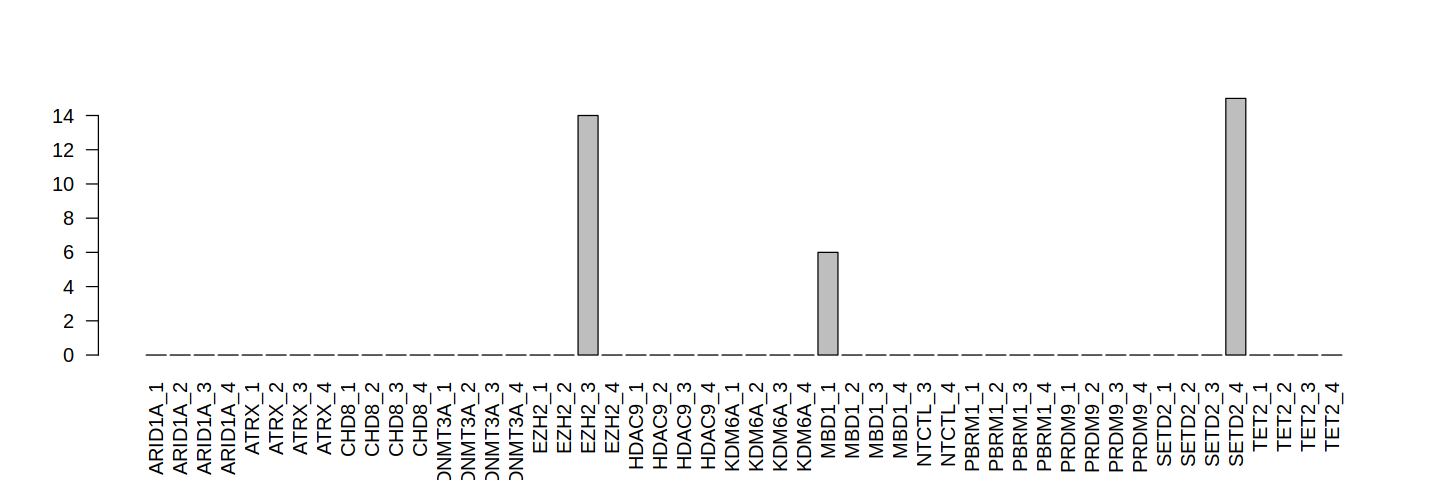

In [ ]:
df_inpection = sample_n(df_unique, 1)
df_inpection
my_cell = df_inpection$cell

options(repr.plot.width = 12, repr.plot.height = 4)
barplot(guide_counts[, my_cell], las=2)

select_cell = gRNA_calls$cell == my_cell
gRNA_calls[select_cell,]

In [ ]:
cell_counts = guide_counts[, my_cell]
#data.frame(cell_counts/sum(cell_counts))
sum(cell_counts)
data.frame(cell_counts) %>% arrange(cell_counts) %>% tail(5)

[1] 34

,cell_counts
,<int>
EZH2_4,2
ATRX_3,5
KDM6A_1,7
EZH2_3,10
NTCTL_3,10


### Inspection before filtering etc 

gRNA,cell,UMI_count,cell_total_UMIs,fraction_total_UMIs,order,prob,gRNA_num,means,nbinom,n,p_adj_nbinom,n_detected_gRNAs_nbinom,n_detected_gRNAs,p_adj
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>
MBD1-2,CGGCTAATCATTTGTC-1,518,828,0.6256,1,0.02,30,34,0.014,24,0.34,1,1,0.34
SETD2-3,CGGCTAATCATTTGTC-1,106,828,0.1280,2,0.02,45,34,0.084,24,1.00,1,1,1.00
KDM6A-1,CGGCTAATCATTTGTC-1,40,828,0.0483,3,0.02,25,34,0.142,24,1.00,1,1,1.00
TET2-3,CGGCTAATCATTTGTC-1,30,828,0.0362,4,0.02,49,34,0.159,24,1.00,1,1,1.00
SETD2-4,CGGCTAATCATTTGTC-1,20,828,0.0242,5,0.02,46,34,0.184,24,1.00,1,1,1.00
EZH2-2,CGGCTAATCATTTGTC-1,13,828,0.0157,6,0.02,18,34,0.211,24,1.00,1,1,1.00
EZH2-3,CGGCTAATCATTTGTC-1,11,828,0.0133,7,0.02,19,34,0.221,24,1.00,1,1,1.00
EZH2-4,CGGCTAATCATTTGTC-1,11,828,0.0133,8,0.02,20,34,0.221,24,1.00,1,1,1.00
MBD1-1,CGGCTAATCATTTGTC-1,9,828,0.0109,9,0.02,29,34,0.233,24,1.00,1,1,1.00


[1] 828

,cell_counts
,<int>
SETD2_4,20
TET2_3,30
KDM6A_1,40
SETD2_3,106
MBD1_2,518


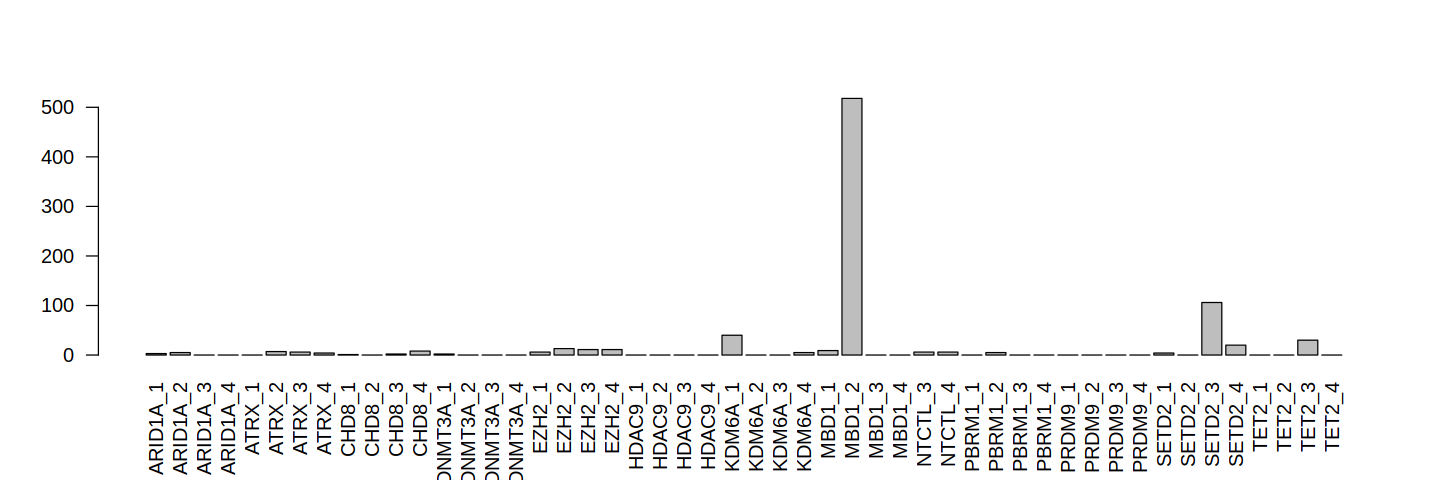

In [ ]:
my_cell = 'AAACAGCCAAGCCACT-1'
my_cell = 'CGGCTAATCATTTGTC-1'

options(repr.plot.width = 12, repr.plot.height = 4)
barplot(guide_counts[, my_cell], las=2)

select_cell = gRNA_calls$cell == my_cell
gRNA_calls[select_cell,]

cell_counts = guide_counts[, my_cell]
#data.frame(cell_counts/sum(cell_counts))
sum(cell_counts)
data.frame(cell_counts) %>% arrange(cell_counts) %>% tail(5)

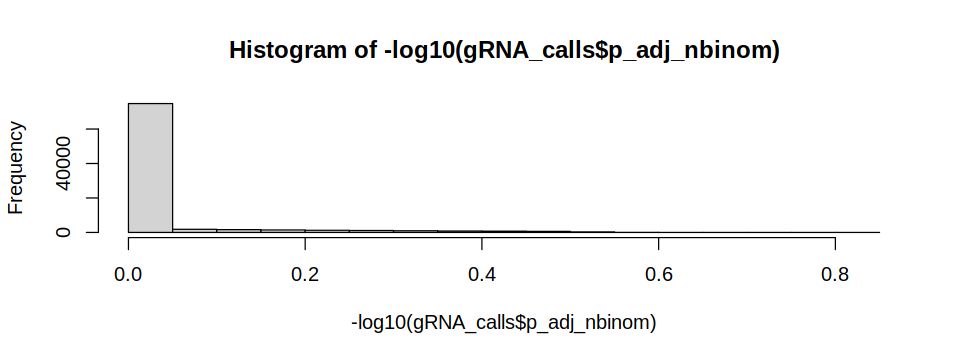

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 3)
hist(-log10(gRNA_calls$p_adj_nbinom))

In [ ]:
p_vals = gRNA_calls$p_adj_nbinom

min(p_vals[!is.na(p_vals)])

[1] 0.15